In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import cv2
import math
from scipy import stats

In [2]:
train_data_path = '/var/scratch/bweel/datasets/cervical/processed/cropped/'

In [3]:
path_type1 = os.path.join(train_data_path, 'Type_1')
path_type2 = os.path.join(train_data_path, 'Type_2')
path_type3 = os.path.join(train_data_path, 'Type_3')


In [4]:
fnames_type1 = [os.path.join(path_type1, f) for f in os.listdir(path_type1)]
fnames_type2 = [os.path.join(path_type2, f) for f in os.listdir(path_type2)]
fnames_type3 = [os.path.join(path_type3, f) for f in os.listdir(path_type3)]

In [10]:
def Rai_space(img, Ra_ratio, a_threshold, limit_radius=True):
    imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB);
    imgGrey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    w = img.shape[0]
    h = img.shape[1]
    max_radius = 0.5* min(w, h)
    Ra = np.zeros((w*h, 3))
    for i in range(w):
        for j in range(h):
            R = math.sqrt((w/2-i)*(w/2-i) + (h/2-j)*(h/2-j))
            Ra[i*h+j, 0] = R
            Ra[i*h+j, 1] = min(imgLab[i][j][1], a_threshold)
            Ra[i*h+j, 2] = imgGrey[i][j]
    
    if limit_radius:
        Ra = Ra[Ra[:,0]>max_radius, :]
    Ra[:,0] /= max(Ra[:,0])
    Ra[:,0] *= Ra_ratio
    Ra[:,1] /= max(Ra[:,1])
    Ra[:,2] /= max(Ra[:,2])
    
    return Ra

In [11]:
def create_feature_vector(img, nr_bins=100):
    # Calculate (Radius, redness, intensity) matrix
    Ra = Rai_space(img, 1.0, 256, limit_radius=True)
    
    # Bin the data based radius and calculate mean and std
    red_means, bin_edges, _ = stats.binned_statistic(Ra[:,0], values=Ra[:,1], statistic='mean', bins=nr_bins)
    red_stds, bin_edges, _ = stats.binned_statistic(Ra[:,0], values=Ra[:,1], statistic=np.std, bins=nr_bins)
    grey_means, bin_edges, _ = stats.binned_statistic(Ra[:,0], values=Ra[:,2], statistic='mean', bins=nr_bins)
    grey_stds, bin_edges, _ = stats.binned_statistic(Ra[:,0], values=Ra[:,2], statistic=np.std, bins=nr_bins)
    return np.array((red_means, red_stds, grey_means, grey_stds)).transpose()

In [12]:
# Creating the dataset
def  data_from_file(fn, nr_bins=100):
    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    v = create_feature_vector(img, nr_bins=nr_bins)
    v = v.flatten()
    return v

In [15]:
X = np.array([data_from_file(f) for f in fnames_type1 + fnames_type2 + fnames_type3])
X.shape

(1481, 400)

In [35]:
X[np.isnan(X)] = 0

In [28]:
y = np.array([1]*len(fnames_type1) + [2]*len(fnames_type2) + [3]*len(fnames_type3))

In [44]:
from sklearn.model_selection import KFold
from sklearn import svm
accuracies = []
k_fold = KFold(n_splits=10, shuffle=True)
for train_indices, val_indices in k_fold.split(X):
    X_train = X[train_indices]
    X_val = X[val_indices]
    y_train = y[train_indices]
    y_val = y[val_indices]
    clf = svm.SVC(kernel='linear').fit(X_train, y_train)
    score = clf.score(X_val, y_val)
    accuracies.append(score)
    print('trainsize: {}, testsize: {}, score: {}'.format(len(train_indices), len(val_indices), score))

trainsize: 1332, testsize: 149, score: 0.5704697986577181
trainsize: 1333, testsize: 148, score: 0.47297297297297297
trainsize: 1333, testsize: 148, score: 0.5135135135135135
trainsize: 1333, testsize: 148, score: 0.5405405405405406
trainsize: 1333, testsize: 148, score: 0.49324324324324326
trainsize: 1333, testsize: 148, score: 0.5405405405405406
trainsize: 1333, testsize: 148, score: 0.5540540540540541
trainsize: 1333, testsize: 148, score: 0.5405405405405406
trainsize: 1333, testsize: 148, score: 0.5202702702702703
trainsize: 1333, testsize: 148, score: 0.527027027027027


In [45]:
np.mean(accuracies)

0.52731725013604214

In [43]:
# Score for always classifying as type 2
len(fnames_type2)/len(y)

0.5273463875759622

In [56]:
test_files = {'Type1': fnames_type1[:10],
              'Type2': fnames_type2[:10],
              'Type3': fnames_type3[:10]}

Type1


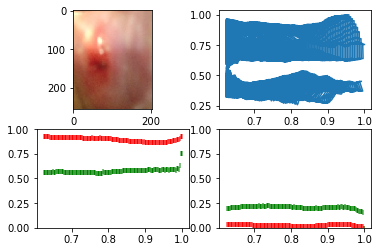

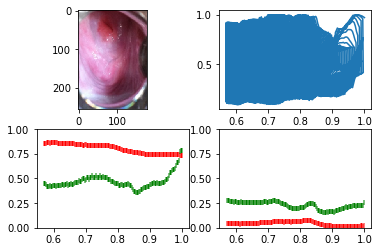

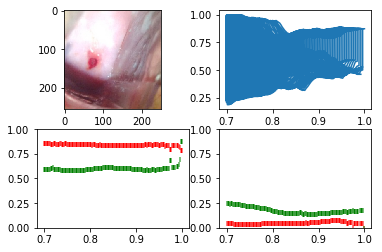

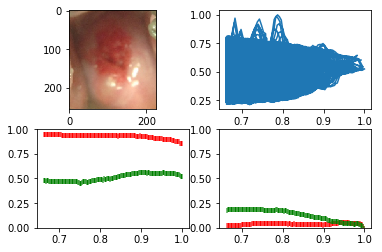

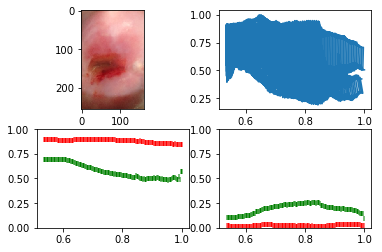

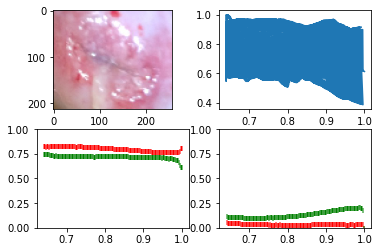

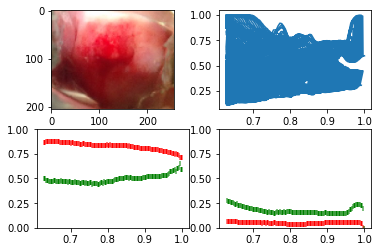

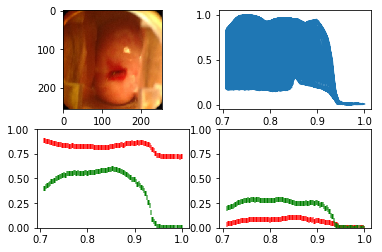

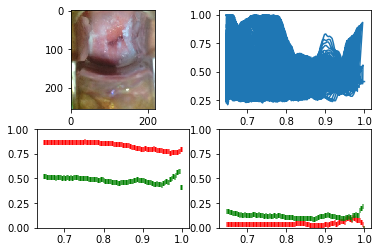

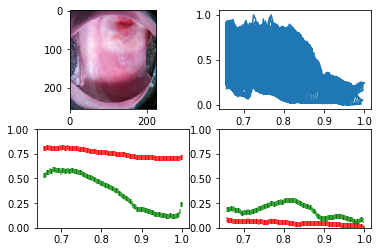

Type2


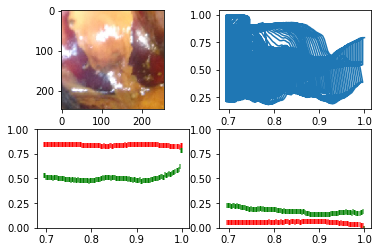

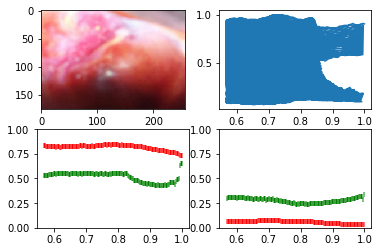

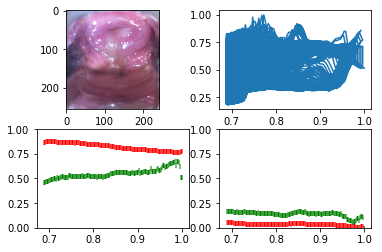

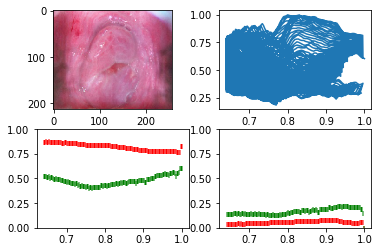

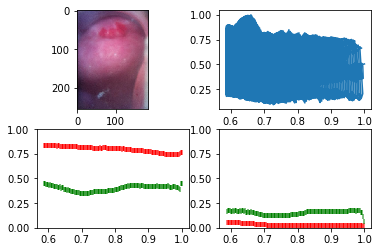

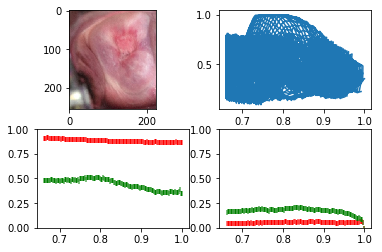

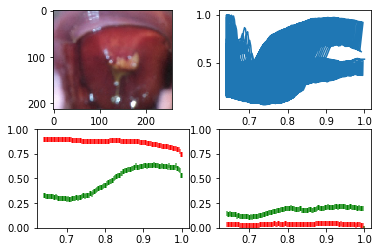

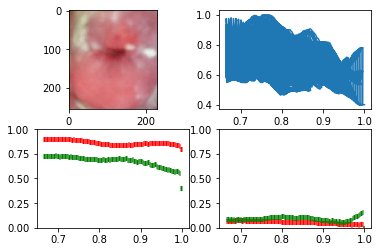

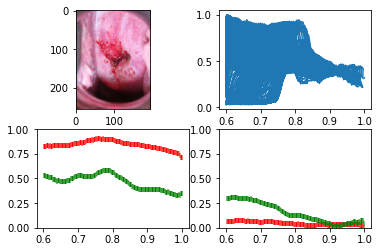

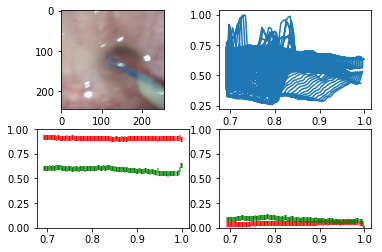

Type3


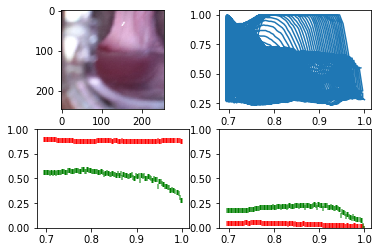

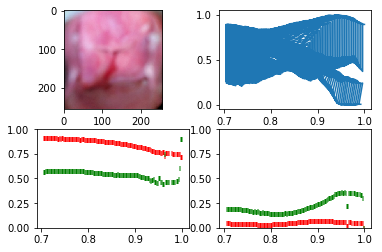

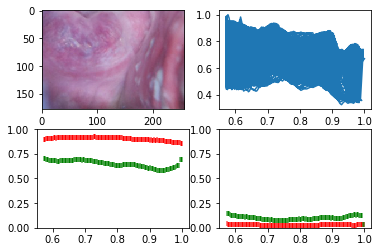

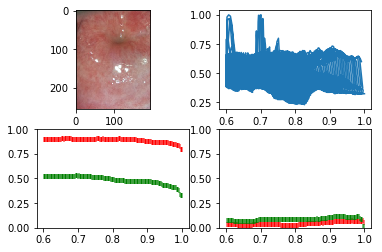

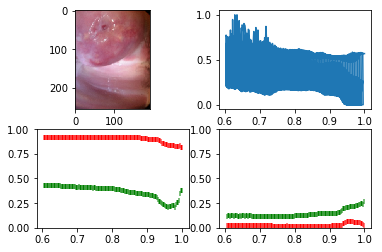

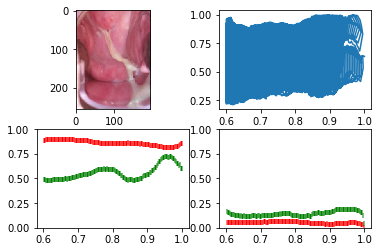

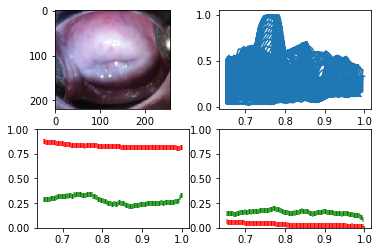

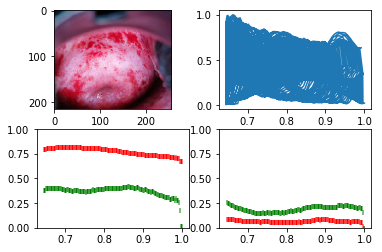

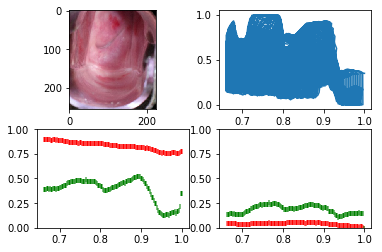

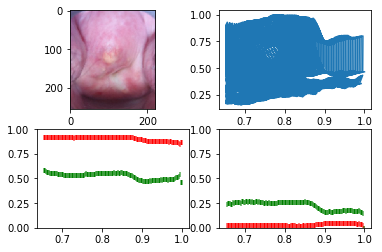

In [64]:
for typ, fnames in test_files.items():
    print(typ)
    for fn in fnames:
        img = cv2.imread(fn)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        Ra = Rai_space(img, 1.0, 256)
        plt.subplot(221)
        plt.imshow(img)
        plt.subplot(222)
        plt.plot(Ra[:,0], Ra[:,2])
        plt.subplot(223)
        bin_means, bin_edges, binnumber = stats.binned_statistic(Ra[:,0], values=Ra[:,1], statistic='mean', bins=100)
        plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5)
        bin_means, bin_edges, binnumber = stats.binned_statistic(Ra[:,0], values=Ra[:,2], statistic='mean', bins=100)
        plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5)
        plt.ylim(0, 1)
        plt.subplot(224)
        bin_means, bin_edges, binnumber = stats.binned_statistic(Ra[:,0], values=Ra[:,1], statistic=np.std, bins=100)
        plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5)
        bin_means, bin_edges, binnumber = stats.binned_statistic(Ra[:,0], values=Ra[:,2], statistic=np.std, bins=100)
        plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=5)
        plt.ylim(0,1)
        plt.show()